In [35]:
!pip install optuna

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
import optuna
import seaborn as sns

In [37]:
# getting data from source
df_genomicMatrix=pd.read_csv('https://ucsc-public-main-xena-hub.s3.us-east-1.amazonaws.com/download/miller2005_public%2Fmiller2005_genomicMatrix.gz',delimiter='\t',header=None)
df_clinicalMatrix=pd.read_csv('https://ucsc-public-main-xena-hub.s3.us-east-1.amazonaws.com/download/miller2005_public%2Fmiller2005_public_clinicalMatrix.gz',delimiter='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251) ha

In [38]:
# first few rows of clinical matrix
df_clinicalMatrix.head(10)

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,_INTEGRATION,_PATIENT,p53DLDAclassResult,p53mutant,_GENOMIC_ID_miller2005
0,X100B08,68,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR-,9.0,X100B08,X100B08,WT-like,p53-,X100B08
1,X101B88,40,No,AliveOrCensored,12.0,ER-,G3,LN-,PgR-,12.0,X101B88,X101B88,MT-like,p53+,X101B88
2,X102B06,51,No,AliveOrCensored,12.0,ER+,G3,LN-,PgR+,26.0,X102B06,X102B06,MT-like,p53+,X102B06
3,X103B41,52,Yes,NaN,NaN,ER-,G3,LN+,PgR-,22.0,X103B41,X103B41,MT-like,p53-,X103B41
4,X104B91,80,Yes,AliveOrCensored,4.0,ER+,G3,NaN,PgR+,24.0,X104B91,X104B91,WT-like,p53+,X104B91
5,X105B13,46,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR+,13.0,X105B13,X105B13,WT-like,p53-,X105B13
6,X106B55,37,No,DeathFromCancer,7.0,ER+,G1,LN-,PgR+,60.0,X106B55,X106B55,WT-like,p53-,X106B55
7,X10B88,70,No,AliveOrCensored,11.0,ER+,G1,LN-,PgR+,50.0,X10B88,X10B88,WT-like,p53-,X10B88
8,X110B34,74,No,AliveOrCensored,12.0,ER+,G2,LN-,PgR+,20.0,X110B34,X110B34,MT-like,p53+,X110B34
9,X111B51,41,No,DeathFromCancer,7.0,ER+,G3,LN-,PgR+,33.0,X111B51,X111B51,MT-like,p53+,X111B51


In [39]:
df_clinicalMatrix.columns

Index(['sampleID', 'AgeAtDiagnosis', 'DLDAerror', 'DSS', 'DSS.time',
       'ERstatus', 'EistonHistologicGrade', 'LymphNodeStatus', 'PgRstatus',
       'TumorSize', '_INTEGRATION', '_PATIENT', 'p53DLDAclassResult',
       'p53mutant', '_GENOMIC_ID_miller2005'],
      dtype='object')

In [40]:
# first few rows of genomic matrix
df_genomicMatrix.head(10)

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,probe,X100B08,X101B88,X102B06,X103B41,X104B91,X105B13,X106B55,X10B88,X110B34,...,X85A03,X86A40,X87A79,X88A67,X8B87,X90A63,X94A16,X96A21,X99A50,X9B52
1,211050_x_at,-0.60609845997949,-0.71211732736651,-0.24902371657542,0.47339419538929,-0.54907184258026,-0.3092005016715,0.41897323719004,-0.3946572303695,-0.47251557515557,...,0.19425738895826,-0.0147835375762102,0.13407539167209,-0.19990245782577,0.11891965170859,-0.37927029343351,0.82007590513398,-0.0455767367670501,-0.0245526540187702,0.27066630092569
2,220399_at,0.297761884637424,0.108554028539094,0.529915688630775,-0.0236977596184555,-0.240674552924416,-0.186094550508416,0.00280455771169397,-0.131805918000736,0.113294687596224,...,0.158997493199424,0.228584615788685,-1.61824983812591,-0.237390400226426,0.228422630263264,-0.433716710549096,-1.76092467281198,0.290774879921944,0.248706789784914,-0.0227919448987057
3,202115_s_at,-0.0207199586993729,-0.329812842420013,-0.455559869614984,0.335866503578156,0.0914735642808466,-0.0649335936114834,0.232192293522567,-0.0245333551689031,0.390957101123317,...,0.611860013300097,0.303447871810647,0.0735930672214167,-0.082834904637803,0.133630190202147,0.0553951474851369,0.0711540480339563,-0.114437082375583,0.242832779585116,0.218242406811207
4,224501_at,0.0191163830257484,-0.508559867759712,0.0562016961050977,-0.0112785620922615,0.189045651599998,0.696562269810068,0.192981870643838,-0.319990873927932,-0.243858578920162,...,0.209863932679728,0.215091978389048,-0.323448141350642,-0.0203078647708521,0.214314624350358,0.212822716079898,0.368002424465348,0.207985730041758,0.267992659684308,0.791908891893848
5,227347_x_at,0.217003285274825,0.750268555716166,0.469504094265635,-0.182405554283685,-0.472259746631345,0.294003049170574,0.147631658679885,0.462857150607994,0.781625005612315,...,-0.792750352948505,0.744522780941135,0.156746782941595,-0.0604454092963254,0.107038907434855,-0.192823561730845,0.0307527555541549,-0.463568592211125,0.116093520978945,-0.142528684288885
6,205483_s_at,-0.959765619734105,-0.739373617253365,0.436695502974866,0.913890761259296,1.18484495173342,-0.921591248427505,-0.976086516126244,1.81810520319521,-0.723100883245385,...,-1.11561706495908,-1.75963015795501,0.355280087728865,0.881458469512495,-0.714931953437455,0.971320638022425,1.83952061250142,-0.695891246645205,-1.02142827267055,1.35853694226627
7,212283_at,0.31905965380238,-0.63507596067365,0.253222377924609,0.134584773097739,0.204097424289389,-1.48858656175022,0.124965967004189,-0.399400768147571,-1.10388472055312,...,-0.0234020299288709,-0.785423593070711,-0.148167985995971,-0.0653804748145212,0.670274920597399,-0.620541625136491,-0.131310737024201,-0.275498863350731,-0.333262132498781,0.217372783731449
8,212285_s_at,0.26743053282687,0.404148351178069,0.236893737236249,0.46841163348552,0.397235706101899,0.47611631765845,0.405963629525349,0.0941344988476995,0.373420130159879,...,0.0205554728932693,-0.606536417971721,-0.162472454063082,-0.520093286319691,0.127405316667399,-0.30007531133036,-0.134719368061351,-0.61724686479563,-0.00359567394769122,-0.083492616828881
9,217419_x_at,0.0546245393746343,0.553476301226864,0.263843536673264,0.508556696455114,0.107319891585904,0.844849143201444,0.0171650830981847,0.264637970710144,0.493297784508725,...,0.018747293370545,-1.03597918814879,-0.0122102766741659,-0.563183591738616,0.252069009905044,-0.227527908675295,-0.0885185694443251,-0.927063458578016,-0.0206992687985554,-0.166205147103785


In [41]:
# transpose of genomic matrix data 
df_genomicMatrix_t=df_genomicMatrix.T

In [42]:
df_genomicMatrix_t.columns = df_genomicMatrix_t.iloc[0] # converting first row into column names 
df_genomicMatrix_t=df_genomicMatrix_t.iloc[1:] # deleting forst row due to duplicate

In [43]:
df_genomicMatrix_t.rename(columns={'probe': 'sampleID'}, inplace=True) # renaming first column to make a join with the clinicalMatrix dataframe

In [44]:
# joining the two dataframes
df_inner = pd.merge(df_genomicMatrix_t, df_clinicalMatrix, on='sampleID',how='inner')
df_inner.head(5)

,sampleID,211050_x_at,220399_at,202115_s_at,224501_at,227347_x_at,205483_s_at,212283_at,212285_s_at,217419_x_at,...,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,_INTEGRATION,_PATIENT,p53DLDAclassResult,p53mutant,_GENOMIC_ID_miller2005
0,X100B08,-0.60609845997949,0.297761884637424,-0.0207199586993729,0.0191163830257484,0.217003285274825,-0.959765619734105,0.31905965380238,0.26743053282687,0.0546245393746343,...,ER+,G1,LN-,PgR-,9.0,X100B08,X100B08,WT-like,p53-,X100B08
1,X101B88,-0.71211732736651,0.108554028539094,-0.329812842420013,-0.508559867759712,0.750268555716166,-0.739373617253365,-0.63507596067365,0.404148351178069,0.553476301226864,...,ER-,G3,LN-,PgR-,12.0,X101B88,X101B88,MT-like,p53+,X101B88
2,X102B06,-0.24902371657542,0.529915688630775,-0.455559869614984,0.0562016961050977,0.469504094265635,0.436695502974866,0.253222377924609,0.236893737236249,0.263843536673264,...,ER+,G3,LN-,PgR+,26.0,X102B06,X102B06,MT-like,p53+,X102B06
3,X103B41,0.47339419538929,-0.0236977596184555,0.335866503578156,-0.0112785620922615,-0.182405554283685,0.913890761259296,0.134584773097739,0.46841163348552,0.508556696455114,...,ER-,G3,LN+,PgR-,22.0,X103B41,X103B41,MT-like,p53-,X103B41
4,X104B91,-0.54907184258026,-0.240674552924416,0.0914735642808466,0.189045651599998,-0.472259746631345,1.18484495173342,0.204097424289389,0.397235706101899,0.107319891585904,...,ER+,G3,NaN,PgR+,24.0,X104B91,X104B91,WT-like,p53+,X104B91


In [45]:
# dropping null and duplicate values
df_inner=df_inner.dropna()
df_inner=df_inner.drop_duplicates()

In [46]:
# Dropping other output variables to predict only PgRstatus
df_inner_1 = df_inner.drop(columns=['AgeAtDiagnosis','DLDAerror', 'DSS', 'DSS.time',
       'ERstatus','LymphNodeStatus', 'EistonHistologicGrade',
       'TumorSize', '_INTEGRATION', '_PATIENT', 'p53DLDAclassResult',
       'p53mutant', '_GENOMIC_ID_miller2005'])

In [47]:
print(df_inner_1['PgRstatus'].value_counts().sort_values(ascending=False))

PgR+    172
PgR-     50
Name: PgRstatus, dtype: int64


In [48]:
# Splitting data into train and test
X=df_inner_1.drop(columns=[ 'PgRstatus','sampleID'],axis=1) 
X=X.apply(pd.to_numeric)
y=df_inner['PgRstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [49]:
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [50]:
sfm = SelectFromModel(clf, threshold=4.0e-05)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10000, n_jobs=-1,
                                                 random_state=0),
                threshold=4e-05)

In [51]:
sfm.get_support(indices=True)

array([    8,    24,    35, ..., 24680, 24707, 24709])

In [52]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [53]:
X_important_train.shape

(148, 5991)

#**XGBClassifier**

In [54]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, .1),
        'subsample': trial.suggest_uniform('subsample', 0.25, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.20, 1),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'objective': 'binary:logistic'
    }
    modelx2 =XGBClassifier(**params)
    modelx2.fit(X_important_train, y_train, verbose=0)
    preds = modelx2.predict(X_important_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy
study = optuna.create_study(direction="maximize")
print(f"Sampler is {study.sampler.__class__.__name__}")
study.optimize(objective, n_trials=50, timeout=1000)
# 

trialx2 = study.best_trial.params
modelx2=XGBClassifier(**trialx2)
modelx2.fit(X_important_train, y_train)

pred=modelx2.predict(X_important_test)
accuracy=accuracy_score(y_test, pred)
print('Accuracy:' ,accuracy*100)

[I 2022-03-10 08:47:28,470] A new study created in memory with name: no-name-055baf68-d85f-46f8-84b2-13bfd1a4a3d0


Sampler is TPESampler


[I 2022-03-10 08:47:33,907] Trial 0 finished with value: 0.7837837837837838 and parameters: {'n_estimators': 121, 'max_depth': 17, 'learning_rate': 0.0557908081186426, 'subsample': 0.5696380272267125, 'colsample_bytree': 0.795603331188854, 'gamma': 7}. Best is trial 0 with value: 0.7837837837837838.
[I 2022-03-10 08:47:38,072] Trial 1 finished with value: 0.8378378378378378 and parameters: {'n_estimators': 336, 'max_depth': 20, 'learning_rate': 0.07189522831327667, 'subsample': 0.27121453063452805, 'colsample_bytree': 0.5418114556170197, 'gamma': 2}. Best is trial 1 with value: 0.8378378378378378.
[I 2022-03-10 08:47:43,164] Trial 2 finished with value: 0.8108108108108109 and parameters: {'n_estimators': 174, 'max_depth': 15, 'learning_rate': 0.07216535793301053, 'subsample': 0.29782304343447197, 'colsample_bytree': 0.9839684229929124, 'gamma': 8}. Best is trial 1 with value: 0.8378378378378378.
[I 2022-03-10 08:47:45,572] Trial 3 finished with value: 0.8243243243243243 and parameters:

Accuracy: 85.13513513513513


              precision    recall  f1-score   support

        PgR+       0.85      0.98      0.91        58
        PgR-       0.86      0.38      0.52        16

    accuracy                           0.85        74
   macro avg       0.85      0.68      0.72        74
weighted avg       0.85      0.85      0.83        74



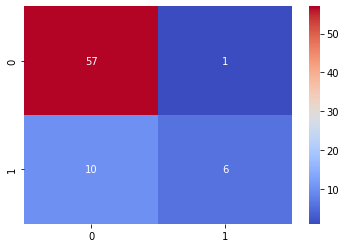

In [55]:
con_mat_1=confusion_matrix(y_test, pred)
sns.heatmap(con_mat_1,cmap = 'coolwarm',annot=True)
print(classification_report(y_test, pred))

#**KNN**

In [56]:
def objective(trial):
   params = {
    'n_neighbors' : trial.suggest_int("n_neighbors", 1, 30),
    'weights' : trial.suggest_categorical("weights", ['uniform', 'distance']),
    'metric' : trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    }
   modelknn =KNeighborsClassifier(**params)
   modelknn.fit(X_important_train, y_train)
   preds = modelknn.predict(X_important_test)
   accuracy = accuracy_score(y_test, preds)
   return accuracy

study = optuna.create_study(direction="maximize")
print(f"Sampler is {study.sampler.__class__.__name__}")
study.optimize(objective, n_trials=50, timeout=1000)

trialknn = study.best_trial.params
modelknn=KNeighborsClassifier(**trialknn)
modelknn.fit(X_important_train, y_train)

pred_2=modelknn.predict(X_important_test)
accuracy=accuracy_score(y_test, pred_2)
print('Accuracy:' ,accuracy*100)

[I 2022-03-10 08:54:55,217] A new study created in memory with name: no-name-c10a0fdf-9226-4fcb-9d5a-9d704c818c33
[I 2022-03-10 08:54:55,237] Trial 0 finished with value: 0.7972972972972973 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7972972972972973.
[I 2022-03-10 08:54:55,252] Trial 1 finished with value: 0.7972972972972973 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7972972972972973.
[I 2022-03-10 08:54:55,269] Trial 2 finished with value: 0.8108108108108109 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 with value: 0.8108108108108109.


Sampler is TPESampler


[I 2022-03-10 08:54:55,287] Trial 3 finished with value: 0.7972972972972973 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 2 with value: 0.8108108108108109.
[I 2022-03-10 08:54:55,302] Trial 4 finished with value: 0.8108108108108109 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.8108108108108109.
[I 2022-03-10 08:54:55,320] Trial 5 finished with value: 0.8243243243243243 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 5 with value: 0.8243243243243243.
[I 2022-03-10 08:54:55,339] Trial 6 finished with value: 0.7972972972972973 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 5 with value: 0.8243243243243243.
[I 2022-03-10 08:54:55,411] Trial 7 finished with value: 0.8108108108108109 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 5 with

Accuracy: 82.43243243243244


              precision    recall  f1-score   support

        PgR+       0.85      0.98      0.91        58
        PgR-       0.86      0.38      0.52        16

    accuracy                           0.85        74
   macro avg       0.85      0.68      0.72        74
weighted avg       0.85      0.85      0.83        74



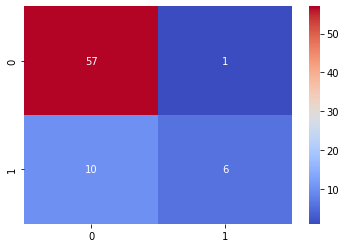

In [57]:
con_mat_2=confusion_matrix(y_test, pred)
sns.heatmap(con_mat_2,cmap = 'coolwarm',annot=True)
print(classification_report(y_test, pred))

#**SVC**

In [58]:
def objective(trial):
    params = {
        'kernel':trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid']),
        'C': trial.suggest_float("C",0.1,3.0,log=True),
        'gamma': trial.suggest_categorical('gamma',['auto','scale']),
        'degree': trial.suggest_int("degree",1,3,log=True),
    }
    modelsvm2 =svm.SVC(**params)
    modelsvm2.fit(X_important_train, y_train)
    preds = modelsvm2.predict(X_important_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy
study = optuna.create_study(direction="maximize")
print(f"Sampler is {study.sampler.__class__.__name__}")
study.optimize(objective, n_trials=50, timeout=100)

trialsvm = study.best_trial.params
modelsvm=svm.SVC(**trialsvm)
modelsvm.fit(X_important_train, y_train)

pred_3=modelsvm.predict(X_important_test)
accuracy=accuracy_score(y_test, pred_3)
print('Accuracy:' ,accuracy*100)

[I 2022-03-10 08:54:57,901] A new study created in memory with name: no-name-284783d5-ff32-47d5-a816-240f13756015


Sampler is TPESampler


[I 2022-03-10 08:54:57,982] Trial 0 finished with value: 0.8378378378378378 and parameters: {'kernel': 'linear', 'C': 0.145723410856505, 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.8378378378378378.
[I 2022-03-10 08:54:58,093] Trial 1 finished with value: 0.8378378378378378 and parameters: {'kernel': 'rbf', 'C': 1.2093175950208985, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.8378378378378378.
[I 2022-03-10 08:54:58,169] Trial 2 finished with value: 0.8378378378378378 and parameters: {'kernel': 'linear', 'C': 1.525274147575587, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.8378378378378378.
[I 2022-03-10 08:54:58,222] Trial 3 finished with value: 0.7837837837837838 and parameters: {'kernel': 'poly', 'C': 0.44366762329522047, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.8378378378378378.
[I 2022-03-10 08:54:58,274] Trial 4 finished with value: 0.7837837837837838 and parameters: {'kernel': 'poly', 'C': 0.14627140835923855

Accuracy: 85.13513513513513


              precision    recall  f1-score   support

        PgR+       0.85      0.98      0.91        58
        PgR-       0.86      0.38      0.52        16

    accuracy                           0.85        74
   macro avg       0.85      0.68      0.72        74
weighted avg       0.85      0.85      0.83        74



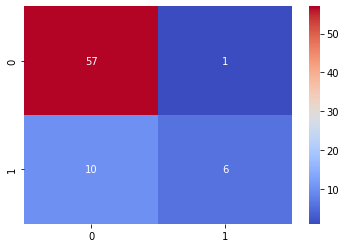

In [59]:
con_mat_3=confusion_matrix(y_test, pred)
sns.heatmap(con_mat_3,cmap = 'coolwarm',annot=True)
print(classification_report(y_test, pred))